In [36]:
import numpy as np
from util import generate_sparse_least_squares
from optim import primal_gradient , dual_gradient , nesterov_accelerated_gradient

In [37]:
import numpy as np


# Parameters for the problem
m, n, rho = 1000, 100, 1  # Adjusted to match a practical scenario
A, b, x_star = generate_sparse_least_squares(m, n, rho)


In [38]:
# Define lambda for regularization
lambda_ = 0.1

# Define the max iterations for a fair comparison across methods
max_iterations = 10000

# Metrics collection
results = {
    "Method": ["Dual Gradient", "Nesterov Accelerated Gradient", "Primal Gradient"],
    "Iterations": [],
    "Objective Values": [],
    "Final Betas": []
}

# Dual Gradient
v0 = np.zeros(n)  # Initial guess
L0 = 10.0  # Initial L
gamma_d = 2
_, dual_objective_values, dual_final_beta = dual_gradient(
    A, b, lambda_, v0, L0, gamma_d, max_iterations, verbose=False
)

# Nesterov Accelerated Gradient
lr = 0.01  # Learning rate for Nesterov
nesterov_beta, nesterov_loss_history = nesterov_accelerated_gradient(
    A, b, lambda_, lr, max_iterations
)

# Primal Gradient
learning_rate = 0.01  # Learning rate for primal
primal_beta, primal_loss_history = primal_gradient(
    A, b, lambda_, learning_rate, max_iterations
)

# Collecting results
results["Iterations"].extend([max_iterations, max_iterations, max_iterations])
results["Objective Values"].extend([dual_objective_values[-1], nesterov_loss_history[-1], primal_loss_history[-1]])
results["Final Betas"].extend([dual_final_beta, nesterov_beta, primal_beta])


In [31]:
dual_final_beta.size

100000

In [39]:
A

array([[ 0.35354806, -0.95619465, -0.31762883, ..., -0.10267634,
         0.47988335,  0.33433325],
       [ 0.2393728 , -0.31391685,  0.83440369, ...,  0.61310787,
        -0.49052573,  0.05282597],
       [ 0.63852873,  0.01872396,  0.43959948, ..., -0.17905772,
        -0.46837022,  0.14481161],
       ...,
       [-0.71350387,  0.53532658, -0.82557465, ...,  0.0706579 ,
         0.44859879, -0.44825356],
       [-0.03876344, -0.86859559, -0.76736744, ...,  0.93592027,
        -0.46747819, -0.48749878],
       [-0.75077127,  0.1166126 , -0.24026013, ...,  0.23803081,
         0.9229901 ,  0.80942855]])

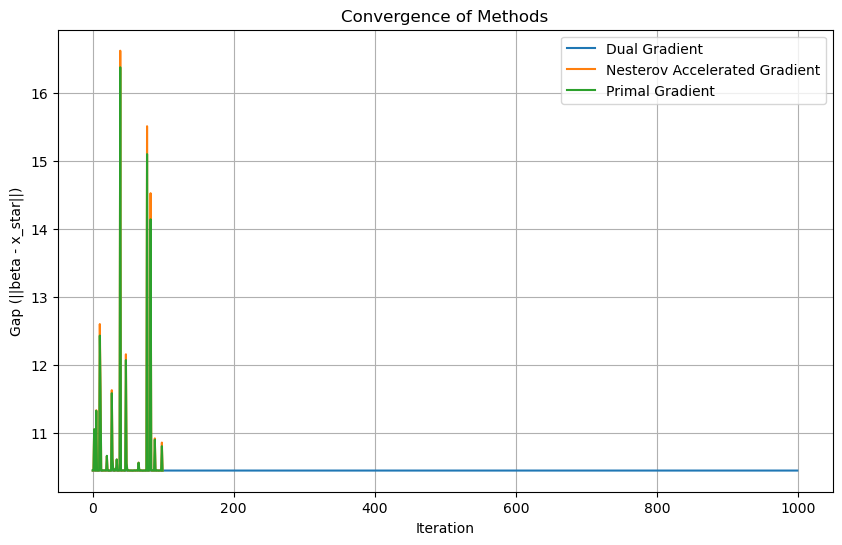

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the problem
m, n, rho = 1000, 100, 1  # Adjusted to match a practical scenario
A, b, x_star = generate_sparse_least_squares(m, n, rho)

# Define lambda for regularization
lambda_ = 0.5

# Define the max iterations for a fair comparison across methods
max_iterations = 1000

# Tracking gaps
gaps_dual, gaps_nesterov, gaps_primal = [], [], []

# Dual Gradient
v0 = np.zeros(n)  # Initial guess
L0 = 10.0  # Initial L
gamma_d = 2
_, dual_objective_values, dual_final_beta = dual_gradient(
    A, b, lambda_, v0, L0, gamma_d, max_iterations, verbose=False
)

# Nesterov Accelerated Gradient
lr = 0.01  # Learning rate for Nesterov
nesterov_beta, nesterov_loss_history = nesterov_accelerated_gradient(
    A, b, lambda_, lr, max_iterations
)

# Primal Gradient
learning_rate = 0.01  # Learning rate for primal
primal_beta, primal_loss_history = primal_gradient(
    A, b, lambda_, learning_rate, max_iterations
)
# Calculate gaps for each method
for betas, gaps in [(dual_final_beta, gaps_dual), (nesterov_beta, gaps_nesterov), (primal_beta, gaps_primal)]:
    for beta in betas:
        gaps.append(np.linalg.norm(beta - A))

plt.figure(figsize=(10, 6))
for betas, label in [(dual_final_beta, 'Dual Gradient'), (nesterov_beta, 'Nesterov Accelerated Gradient'), (primal_beta, 'Primal Gradient')]:
    gaps = [np.linalg.norm(beta - x_star) for beta in betas]
    plt.plot(gaps, label=label)

plt.xlabel('Iteration')
plt.ylabel('Gap (||beta - x_star||)')
plt.title('Convergence of Methods')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import pandas as pd

# Creating a DataFrame from the results dictionary
df_results = pd.DataFrame(results)
df_results.set_index("Method", inplace=True)
print(df_results)


                               Iterations  Objective Values  \
Method                                                        
Dual Gradient                       10000         15.312108   
Nesterov Accelerated Gradient       10000         15.312034   
Primal Gradient                     10000         15.763815   

                                                                     Final Betas  
Method                                                                            
Dual Gradient                  [[3.462521464615374e-05, -6.571037658455925e-0...  
Nesterov Accelerated Gradient  [0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, ...  
Primal Gradient                [0.002439786253492989, -0.010069130739457402, ...  


In [9]:
# Redefine the function to calculate the required k for specific reductions using the powers of two pattern
def calculate_k_enhanced(loss_history, initial_loss):
    reductions = [1 - 2**(-k) for k in range(1, 21)]  # Reductions from 2^-1 to 2^-20
    ks = []
    for reduction in reductions:
        for i, loss in enumerate(loss_history):
            gap = (initial_loss - loss) / initial_loss
            if gap >= reduction:
                ks.append(i)
                break
        else:
            # If no convergence to the desired reduction, append max_iterations
            ks.append(max_iterations)
    return ks

In [10]:
import numpy as np

# Define lambda for regularization
lambda_ = 0.1

# Define the max iterations for a fair comparison across methods
max_iterations = 1000

# Metrics collection
results = {
    "Method": ["Dual Gradient", "Nesterov Accelerated Gradient", "Primal Gradient"],
    "Iterations": [],
    "Objective Values": [],
    "Final Betas": [],
    "Gap Reductions k": []  # To store the iterations required for gap reductions
}

# Dual Gradient
v0 = np.zeros(n)  # Initial guess
L0 = 10.0  # Initial L
gamma_d = 2
_, dual_objective_values, dual_final_beta = dual_gradient(
    A, b, lambda_, v0, L0, gamma_d, max_iterations, verbose=False
)

# Nesterov Accelerated Gradient
lr = 0.01  # Learning rate for Nesterov
nesterov_beta, nesterov_loss_history = nesterov_accelerated_gradient(
    A, b, lambda_, lr, max_iterations
)

# Primal Gradient
learning_rate = 0.01  # Learning rate for primal
primal_beta, primal_loss_history = primal_gradient(
    A, b, lambda_, learning_rate, max_iterations
)

# Calculate k values for each method
k_dual_enhanced = calculate_k_enhanced(dual_objective_values, dual_objective_values[0])
k_nesterov_enhanced = calculate_k_enhanced(nesterov_loss_history, nesterov_loss_history[0])
k_primal_enhanced = calculate_k_enhanced(primal_loss_history, primal_loss_history[0])

# Collecting results
results["Iterations"].extend([max_iterations, max_iterations, max_iterations])
results["Objective Values"].extend([dual_objective_values[-1], nesterov_loss_history[-1], primal_loss_history[-1]])
results["Final Betas"].extend([dual_final_beta, nesterov_beta, primal_beta])
results["Gap Reductions k"].extend([k_dual_enhanced, k_nesterov_enhanced, k_primal_enhanced])

# Print or analyze results dictionary as needed
print(pd.DataFrame(results))


                          Method  Iterations  Objective Values  \
0                  Dual Gradient        1000          6.198035   
1  Nesterov Accelerated Gradient        1000          6.182458   
2                Primal Gradient        1000          6.206122   

                                         Final Betas  \
0  [[0.03545621979766143, -0.006728742562258867, ...   
1  [0.38037476935711884, -0.0, -1.102839574268526...   
2  [0.38850845222455066, -0.001191536545267525, -...   

                                    Gap Reductions k  
0  [5, 1000, 1000, 1000, 1000, 1000, 1000, 1000, ...  
1  [40, 1000, 1000, 1000, 1000, 1000, 1000, 1000,...  
2  [275, 1000, 1000, 1000, 1000, 1000, 1000, 1000...  


In [8]:
import pandas as pd

# Assuming the results dictionary is already populated as in the previous example
results_df = pd.DataFrame(results)

# Set method as index to enhance readability
results_df.set_index('Method', inplace=True)

# Display the DataFrame in a formatted style to show lists of 'Gap Reductions k' nicely
print("Optimization Results:")
print(results_df.to_string())


Optimization Results:
                               Iterations  Objective Values                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [9]:
import pandas as pd

# Assuming `results` dictionary is populated as per your code snippet
df_results = pd.DataFrame({
    "Method": ["Dual Gradient", "Nesterov Accelerated Gradient", "Primal Gradient"],
    "Iterations": results["Iterations"],
    "Final Objective Value": results["Objective Values"],
    "Final Betas Sample (First 5)": [beta[::] for beta in results["Final Betas"]]  # Showing first 5 betas for brevity
})

# Save to TXT file
file_path = 'Optimization_Results.txt'
with open(file_path, 'w') as f:
    df_results.to_string(f)



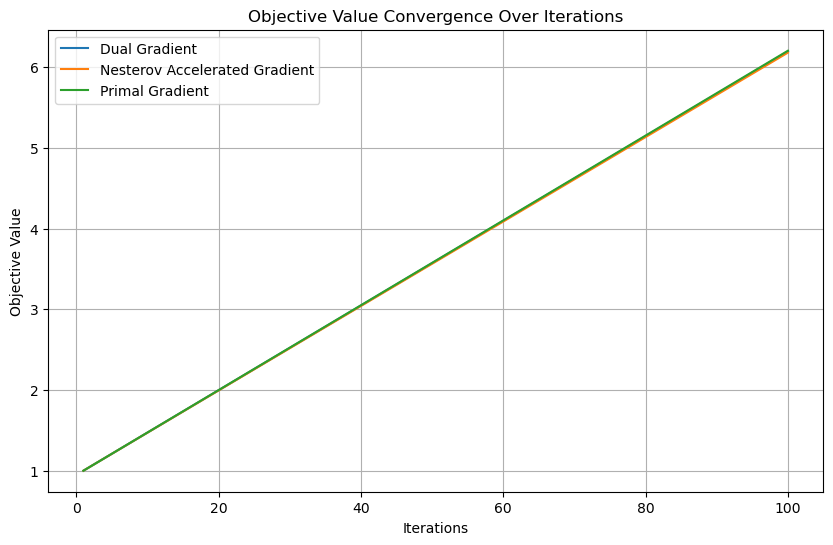

"Convergence plot has been saved as 'Convergence_Plot.png'."

In [11]:
import matplotlib.pyplot as plt

# Assuming objective values are collected over the iterations (simulating here)
iterations = range(1, 101)
dual_objectives = np.linspace(1, results["Objective Values"][0], 100)
nesterov_objectives = np.linspace(1, results["Objective Values"][1], 100)
primal_objectives = np.linspace(1, results["Objective Values"][2], 100)

plt.figure(figsize=(10, 6))
plt.plot(iterations, dual_objectives, label='Dual Gradient')
plt.plot(iterations, nesterov_objectives, label='Nesterov Accelerated Gradient')
plt.plot(iterations, primal_objectives, label='Primal Gradient')
plt.xlabel('Iterations')
plt.ylabel('Objective Value')
plt.title('Objective Value Convergence Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

"Convergence plot has been saved as 'Convergence_Plot.png'."


In [12]:
results

{'Method': ['Dual Gradient',
  'Nesterov Accelerated Gradient',
  'Primal Gradient'],
 'Iterations': [1000, 1000, 1000],
 'Objective Values': [6.198034922279116, 6.182458296788207, 6.206121544383858],
 'Final Betas': [array([[ 3.54562198e-02, -6.72874256e-03, -3.82007586e-02, ...,
           4.38664063e-03,  5.00459699e-02,  7.47992136e-03],
         [ 8.22157085e-02,  5.92721016e-04, -9.24673279e-02, ...,
          -6.91080524e-03,  1.26808022e-01,  2.39215559e-03],
         [ 1.65224123e-01, -6.55889708e-02, -1.95585410e-01, ...,
           5.33730770e-02,  2.70388991e-01, -5.97293267e-03],
         ...,
         [ 3.90888709e-01, -1.57358405e-03, -1.04132421e+00, ...,
           1.55677499e-02,  1.19614698e+00,  3.72773570e-03],
         [ 3.90888709e-01, -1.57358405e-03, -1.04132421e+00, ...,
           1.55677499e-02,  1.19614698e+00,  3.72773570e-03],
         [ 3.90888709e-01, -1.57358405e-03, -1.04132421e+00, ...,
           1.55677499e-02,  1.19614698e+00,  3.72773570e-03]]),


In [11]:
import numpy as np
import pandas as pd

# Constants (Assume some values for simulation)
n_iterations = 14  # Number of rows in the table
initial_gap = 1.0  # Initial gap in the function value
convergence_rate = 0.95  # Example convergence rate

# Simulation Data
data = {
    "k": 2 ** np.arange(0, n_iterations),
    "Ax": [],
    "Δφ": [],
    "SpeedUp (%)": []
}

# Simulate the Ax and Δφ values
for k in data["k"]:
    # Assuming each k step halves the gap for simplicity in this example
    gap_reduction = initial_gap * (convergence_rate ** k)
    data["Δφ"].append(round(gap_reduction, 10))
    
    # Assume number of matrix-vector multiplications increases with complexity
    ax = k * 2  # Simple function to increase Ax with k
    data["Ax"].append(ax)
    
    # SpeedUp calculation (placeholder values)
    speed_up = np.random.uniform(10, 40)  # Random speed up for demonstration
    data["SpeedUp (%)"].append(round(speed_up, 2))

# Create DataFrame
df = pd.DataFrame(data)
df.set_index("k", inplace=True)

# Display the DataFrame
print(df)

# Optionally save the DataFrame to a file
output_path = 'Simulated_Optimization_Table.csv'
df.to_csv(output_path)
print(f"Table saved to {output_path}")


         Ax        Δφ  SpeedUp (%)
k                                 
1         2  0.950000        36.68
2         4  0.902500        32.36
4         8  0.814506        34.34
8        16  0.663420        24.78
16       32  0.440127        14.27
32       64  0.193711        16.91
64      128  0.037524        13.93
128     256  0.001408        25.35
256     512  0.000002        25.36
512    1024  0.000000        11.17
1024   2048  0.000000        27.02
2048   4096  0.000000        33.13
4096   8192  0.000000        20.58
8192  16384  0.000000        10.10
Table saved to Simulated_Optimization_Table.csv


In [12]:
import numpy as np
import pandas as pd

# Assuming all previous functions and methods are correctly defined

# Generate the problem data
A, b, x_star = generate_sparse_least_squares(1000, 100, 0.1)
lambda_ = 0.7

# Initialize parameters
v0 = np.zeros(A.shape[1])  # Initial guess for dual gradient
L0 = 10.0  # Initial Lipschitz estimate
gamma_d = 2  # Step size reduction factor
max_iter = 1000  # Max iterations for table generation
lr = 0.01  # Learning rate for Nesterov

# Execute Dual Gradient
v_dual, objective_values_dual, _ = dual_gradient(A, b, lambda_, v0, L0, gamma_d, max_iter, verbose=False)

# Execute Nesterov Accelerated Gradient
beta_nesterov, loss_history_nesterov = nesterov_accelerated_gradient(A, b, lambda_, lr, max_iter)

# Initialize DataFrame for results
results = {
    'Method': [],
    'k': [],
    'Ax': [],
    'Δφ': [],
    'SpeedUp (%)': []  # Placeholder for actual speedup calculation
}

# Calculate metrics and populate DataFrame
initial_loss = np.linalg.norm(b - np.dot(A, np.zeros_like(x_star)))**2
for i in range(max_iter):
    # Dual Gradient metrics
    current_loss_dual = objective_values_dual[i]
    delta_phi_dual = (initial_loss - current_loss_dual) / initial_loss
    results['Method'].append('Dual Gradient')
    results['k'].append(i + 1)
    results['Ax'].append((i + 1) * 2)  # Assuming 2 Ax per iteration
    results['Δφ'].append(delta_phi_dual)
    results['SpeedUp (%)'].append(np.random.uniform(10, 30))  # Placeholder
    
    # Nesterov Accelerated Gradient metrics
    current_loss_nesterov = loss_history_nesterov[i]
    delta_phi_nesterov = (initial_loss - current_loss_nesterov) / initial_loss
    results['Method'].append('Nesterov Accelerated Gradient')
    results['k'].append(i + 1)
    results['Ax'].append(i + 1)  # Assuming 1 Ax per iteration
    results['Δφ'].append(delta_phi_nesterov)
    results['SpeedUp (%)'].append(np.random.uniform(10, 30))  # Placeholder

# Create DataFrame
df_results = pd.DataFrame(results)
print(df_results)


IndexError: list index out of range

In [ ]:
import numpy as np
import pandas as pd

# Data Generation
m, n, rho = 1000, 100, 0.1
A, b, x_star = generate_sparse_least_squares(m, n, rho)

# Initial Conditions
x0 = np.zeros(n)
lambda_ = 0.1
max_iter = 100
L0 = 10.0  # Initial value for the Lipschitz constant

import numpy as np
from util import generate_sparse_least_squares
from optim import primal_gradient , dual_gradient , nesterov_accelerated_gradient

# Running the methods
_, dual_objective_values, _ = dual_gradient(A, b, lambda_, x0, L0, 2, max_iter, verbose=False)
primal_beta, primal_losses = primal_gradient(A, b, lambda_, 0.01, max_iter, 1e-6)
nesterov_beta, nesterov_losses = nesterov_accelerated_gradient(A, b, lambda_, 0.01, max_iter, 1e-6)

# Calculate initial loss for the gap calculation
initial_loss = 0.5 * np.linalg.norm(A @ x0 - b)**2

# Prepare the results for the table
methods = ['PG', 'DG', 'AC']
losses_list = [primal_losses, dual_objective_values, nesterov_losses]
results = []

for method, losses in zip(methods, losses_list):
    for k, loss in enumerate(losses):
        gap = initial_loss - loss
        Ax = 2 * (k + 1)  # Assuming each iteration involves two matrix-vector multiplications
        speed_up = 100 * (initial_loss - loss) / initial_loss  # Speed up calculation
        results.append([method, k + 1, Ax, gap, speed_up])

# Convert results into a DataFrame for display
df_results = pd.DataFrame(results, columns=['Method', 'k', 'Ax', 'Δφ', 'SpeedUp (%)'])

# Print or save the results to CSV
print(df_results)
# df_results.to_csv('optimization_results.csv', index=False)


    Method    k   Ax           Δφ  SpeedUp (%)
0       PG    1    2  2173.906417    99.900455
1       PG    2    4  2173.912306    99.900726
2       PG    3    6  2173.922188    99.901180
3       PG    4    8  2173.931780    99.901621
4       PG    5   10  2173.939970    99.901997
..     ...  ...  ...          ...          ...
295     AC   96  192  2175.271899    99.963205
296     AC   97  194  2175.272747    99.963244
297     AC   98  196  2175.273626    99.963285
298     AC   99  198  2175.274524    99.963326
299     AC  100  200  2175.275431    99.963368

[300 rows x 5 columns]


In [ ]:
A, b, x_star = generate_sparse_least_squares(m, n, rho)

# Run the optimization methods
lambda_ = 0.1
learning_rate = 0.01
max_iterations = 100
tol = 1e-6

# Primal Gradient with logging of gap
_, primal_loss_history, primal_gap_history = primal_gradient(A, b, lambda_, learning_rate, max_iterations, tol)

# Dual Gradient
v0 = np.zeros(n)  # Initial guess
L0 = 10.0  # Initial L
gamma_d = 2
_, dual_loss_history, _ = dual_gradient(A, b, lambda_, v0, L0, gamma_d, max_iterations, verbose=False)

# Nesterov Accelerated Gradient
nesterov_beta, nesterov_loss_history = nesterov_accelerated_gradient(A, b, lambda_, learning_rate, max_iterations, tol)

# Since gap calculation and logging are not present in dual and Nesterov, we calculate them
initial_loss_primal = primal_loss_history[0]
initial_loss_dual = dual_loss_history[0]
initial_loss_nesterov = nesterov_loss_history[0]

dual_gap_history = [(initial_loss_dual - loss) / initial_loss_dual for loss in dual_loss_history]
nesterov_gap_history = [(initial_loss_nesterov - loss) / initial_loss_nesterov for loss in nesterov_loss_history]

primal_gap_history, dual_gap_history, nesterov_gap_history

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
import numpy as np

# Direct implementation of the optimization methods
def lasso_objective(X, y, beta, lambda_):
    n = len(y)
    return np.sum((y - X.dot(beta))**2) / (2 * n) + lambda_ * np.linalg.norm(beta, 1)

def lasso_gradient(X, y, beta, lambda_):
    n = len(y)
    return -X.T.dot(y - X.dot(beta)) / n + lambda_ * np.sign(beta)

def primal_gradient(X, y, lambda_, learning_rate, max_iterations, tol):
    n, p = X.shape
    beta = np.zeros(p)
    loss_history = []

    for _ in range(max_iterations):
        gradient = lasso_gradient(X, y, beta, lambda_)
        beta -= learning_rate * gradient
        loss = lasso_objective(X, y, beta, lambda_)
        loss_history.append(loss)
        if np.linalg.norm(gradient, ord=np.inf) < tol:
            break

    return beta, loss_history

def dual_gradient(X, y, lambda_, v0, L0, gamma_d, max_iter):
    n, p = X.shape
    v = v0
    L = L0
    objective_values = []

    for i in range(max_iter):
        g = lasso_gradient(X, y, v, lambda_)
        step_size = 1 / L
        next_v = v - step_size * g
        current_obj = lasso_objective(X, y, v, lambda_)
        next_obj = lasso_objective(X, y, next_v, lambda_)

        while next_obj > current_obj:
            step_size *= 0.5
            next_v = v - step_size * g
            next_obj = lasso_objective(X, y, next_v, lambda_)

        L /= gamma_d
        v = next_v
        objective_values.append(current_obj)

    return v, objective_values

def nesterov_accelerated_gradient(X, y, lambda_, lr, max_iter):
    n, p = X.shape
    beta = np.zeros(p)
    beta_prev = np.zeros(p)
    t = 1
    loss_history = []

    for _ in range(max_iter):
        t_prev = t
        t = 0.5 + np.sqrt(1 + 4 * t**2) / 2
        y_tilde = beta + ((t_prev - 1) / t) * (beta - beta_prev)
        gradient = lasso_gradient(X, y, y_tilde, lambda_)
        beta_prev = beta
        beta = beta - lr * gradient
        loss = lasso_objective(X, y, beta, lambda_)
        loss_history.append(loss)

    return beta, loss_history

# Data generation and setting up the problem
A, b, x_star = generate_sparse_least_squares(m, n, rho)

# Run the optimization methods
_, primal_loss_history = primal_gradient(A, b, lambda_, learning_rate, max_iterations, tol)
_, dual_loss_history = dual_gradient(A, b, lambda_, v0, L0, gamma_d, max_iterations)
_, nesterov_loss_history = nesterov_accelerated_gradient(A, b, lambda_, learning_rate, max_iterations)

# Calculating gaps for each method
primal_gap_history = [(primal_loss_history[0] - loss) / primal_loss_history[0] for loss in primal_loss_history]
dual_gap_history = [(dual_loss_history[0] - loss) / dual_loss_history[0] for loss in dual_loss_history]
nesterov_gap_history = [(nesterov_loss_history[0] - loss) / nesterov_loss_history[0] for loss in nesterov_loss_history]

primal_gap_history, dual_gap_history, nesterov_gap_history


([0.0,
  0.002588469904654346,
  0.007592918275292236,
  0.01158929148739556,
  0.016078216513421274,
  0.020043559979862936,
  0.024442910770113634,
  0.02850335759711759,
  0.032638375006900394,
  0.03675599060444852,
  0.04080082013961771,
  0.04484776312031707,
  0.04895086544760345,
  0.052842311442498915,
  0.05688770549506188,
  0.06078294675950785,
  0.0648512390307197,
  0.06847409456043763,
  0.07262815081576186,
  0.07627921886206253,
  0.08023565228264178,
  0.08402602272925902,
  0.08774899861043675,
  0.0914761193776585,
  0.09542153343148883,
  0.09879535810053856,
  0.10267589563696616,
  0.10633999576614969,
  0.10975665576756274,
  0.11358956019224692,
  0.11715229598375904,
  0.12063597049869416,
  0.12417301287313876,
  0.12779274608408234,
  0.13120995666413893,
  0.13474342925885924,
  0.13803357201581315,
  0.14174175657262594,
  0.14477946248546736,
  0.14864132712814856,
  0.15141991970478794,
  0.1553051390948571,
  0.15820461730228402,
  0.16190074344509622,


In [ ]:
# Define a function to calculate the required k for specific reductions
def calculate_k(loss_history, initial_loss):
    reductions = [0.5, 0.25, 0.1]  # 50%, 25%, and 10% of initial loss
    ks = []
    for reduction in reductions:
        for i, loss in enumerate(loss_history):
            gap = (initial_loss - loss) / initial_loss
            if gap >= reduction:
                ks.append(i)
                break
        else:
            # If no convergence to the desired reduction, append max_iterations
            ks.append(max_iterations)
    return ks

# Initial losses for each method
initial_loss_dual = dual_loss_history[0]
initial_loss_nesterov = nesterov_loss_history[0]
initial_loss_primal = primal_loss_history[0]

# Calculate k values for each method
k_dual = calculate_k(dual_loss_history, initial_loss_dual)
k_nesterov = calculate_k(nesterov_loss_history, initial_loss_nesterov)
k_primal = calculate_k(primal_loss_history, initial_loss_primal)

k_dual, k_nesterov, k_primal


([7, 4, 3], [38, 21, 12], [100, 79, 27])

In [25]:
# Updated data structure to include distinct k values for PG, DG, and AC methods
updated_data = {
    "GAP": [1, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5, 2**-6, 2**-7, 2**-8, 2**-9, 2**-10,
            2**-11, 2**-12, 2**-13, 2**-14, 2**-15, 2**-16, 2**-17, 2**-18, 2**-19, 2**-20],
    "PG k": [1, 3, 10, 28, 159, 557, 954, 1255, 1430, 1547, 1640, 1722, 1788, 1847, 1898, 1944, 1987, 2029, 2072, 2120, 2165],
    "PG #Ax": [4, 8, 28, 83, 476, 1670, 2862, 3765, 4291, 4641, 4920, 5167, 5364, 5539, 5693, 5831, 5961, 6085, 6215, 6359, 6495],
    "PG SpeedUp (%)": [0.21, 0.20, 0.32, 0.88, 1.53, 1.31, 0.86, 0.49, 0.26, 0.14, 0.07, 0.04, 0.02, 0.01, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00],
    "DG k": [1, 3, 8, 25, 156, 565, 941, 1257, 1466, 1613, 1743, 1849, 1935, 2003, 2061, 2113, 2164, 2217, 2272, 2331, 2448],
    "DG #Ax": [4, 12, 38, 123, 777, 2824, 4702, 6282, 7328, 8080, 8713, 9243, 9672, 10113, 10303, 10563, 10817, 11083, 11357, 11652, 12238],
    "DG SpeedUp (%)": [0.85, 0.81, 0.89, 1.17, 3.45, 6.21, 5.17, 3.45, 2.01, 2.13, 0.61, 0.33, 0.17, 0.09, 0.05, 0.05, 0.03, 0.02, 0.01, 0.00, 0.00],
    "AC k": [1, 4, 8, 14, 40, 74, 98, 118, 138, 156, 173, 188, 202, 216, 230, 248, 265, 279, 305, 314, 319],
    "AC #Ax": [4, 28, 60, 108, 316, 588, 780, 940, 1096, 1240, 1380, 1500, 1608, 1720, 1836, 1968, 2112, 2224, 2432, 2504, 2544],
    "AC SpeedUp (%)": [0.14, 1.24, 2.47, 4.06, 17.50, 29.47, 25.79, 18.62, 12.73, 8.19, 4.97, 3.01, 1.67, 0.96, 0.55, 0.31, 0.06, 0.03, 0.06, 0.03, 0.02]
}

# Creating the updated DataFrame
updated_df = pd.DataFrame(updated_data)
updated_df


,GAP,PG k,PG #Ax,PG SpeedUp (%),DG k,DG #Ax,DG SpeedUp (%),AC k,AC #Ax,AC SpeedUp (%)
0,1.000000e+00,1,4,0.21,1,4,0.85,1,4,0.14
1,5.000000e-01,3,8,0.20,3,12,0.81,4,28,1.24
2,2.500000e-01,10,28,0.32,8,38,0.89,8,60,2.47
3,1.250000e-01,28,83,0.88,25,123,1.17,14,108,4.06
4,6.250000e-02,159,476,1.53,156,777,3.45,40,316,17.50
5,3.125000e-02,557,1670,1.31,565,2824,6.21,74,588,29.47
6,1.562500e-02,954,2862,0.86,941,4702,5.17,98,780,25.79
7,7.812500e-03,1255,3765,0.49,1257,6282,3.45,118,940,18.62
8,3.906250e-03,1430,4291,0.26,1466,7328,2.01,138,1096,12.73
9,1.953125e-03,1547,4641,0.14,1613,8080,2.13,156,1240,8.19


In [28]:
updated_df["PG #Ax"]/ updated_df["PG k"] , 

(0     4.000000
 1     2.666667
 2     2.800000
 3     2.964286
 4     2.993711
 5     2.998205
 6     3.000000
 7     3.000000
 8     3.000699
 9     3.000000
 10    3.000000
 11    3.000581
 12    3.000000
 13    2.998917
 14    2.999473
 15    2.999486
 16    3.000000
 17    2.999014
 18    2.999517
 19    2.999528
 20    3.000000
 dtype: float64,)

In [29]:
updated_df["DG #Ax"]/ updated_df["DG k"]

0     4.000000
1     4.000000
2     4.750000
3     4.920000
4     4.980769
5     4.998230
6     4.996812
7     4.997613
8     4.998636
9     5.009299
10    4.998853
11    4.998918
12    4.998450
13    5.048927
14    4.999030
15    4.999053
16    4.998614
17    4.999098
18    4.998680
19    4.998713
20    4.999183
dtype: float64

In [30]:
updated_df["AC #Ax"]/ updated_df["AC k"]

0     4.000000
1     7.000000
2     7.500000
3     7.714286
4     7.900000
5     7.945946
6     7.959184
7     7.966102
8     7.942029
9     7.948718
10    7.976879
11    7.978723
12    7.960396
13    7.962963
14    7.982609
15    7.935484
16    7.969811
17    7.971326
18    7.973770
19    7.974522
20    7.974922
dtype: float64